# PPO

## Imports and hyperparameters

In [102]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

import random
import math
import time

import matplotlib.pyplot as plt

import gymnasium as gym

In [205]:
env = gym.make('CartPole-v1')

N_OBSERVATIONS = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

# Hyperparameters
N_AGENTS = 10
T = 100
GAMMA = 0.995
EPSILON = 0.2
H = 0.01 # Entropy constant
V = 0.1 # Value constant
LR = 1e-4
BATCH_SIZE = 128
N_EPOCHS = 7
N_TRAIN_LOOPS = 20

TEST = False
TRAIN = True

layer_dim = 128

## Model and selecting actions

### Model

I'll use the same parameters for the policy and value networks. If this doesn't work well I can change it later.

In [136]:
class PolicyAndValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(N_OBSERVATIONS, layer_dim),
            nn.ReLU(),
            nn.Linear(layer_dim, layer_dim),
            nn.ReLU(),
            nn.Linear(layer_dim, layer_dim),
            nn.ReLU(),
            # +1 comes from value prediction
            nn.Linear(layer_dim, N_ACTIONS + 1)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

### Select action

Select action based on log probabilities.

In [137]:
def select_action(action_logits):
    action_probs = torch.softmax(action_logits, dim=0)
    action = torch.multinomial(action_probs, num_samples=1).item()
    return action

### Test

In [138]:
if TEST:
    test_env = gym.make('CartPole-v1', render_mode='human')
    test_model = PolicyAndValueNetwork()

    for _ in range(1):
        state, info = test_env.reset()
        terminated, truncated = False, False
        while not (terminated or truncated):
            tensor_state = torch.from_numpy(state)
            logits = test_model(tensor_state)
            action_logits = logits[:-1]
            action = select_action(action_logits)
            state, reward, terminated, truncated, info = test_env.step(action)

    test_env.close()

## Data

### Data collector

We first collect the data while marking episode ends when they happen.

In [139]:
class DataCollector():
    def __init__(self):
        self.states = [[] for _ in range(N_AGENTS)]
        self.actions = [[] for _ in range(N_AGENTS)]
        self.rewards = [[] for _ in range(N_AGENTS)]
        self.pis = [[] for _ in range(N_AGENTS)]
        self.episode_ends = [[] for _ in range(N_AGENTS)]

    def add_step(self, agent_id, state, action, reward, pi):
        self.states[agent_id].append(state)
        self.actions[agent_id].append(action)
        self.rewards[agent_id].append(reward)
        self.pis[agent_id].append(pi)

    def mark_episode_end(self, agent_id, timestep):
        self.episode_ends[agent_id].append(timestep)

    def fetch_data(self):
        list_of_agent_states = [torch.stack(agent_states) for agent_states in self.states]
        states = torch.stack([agent_states for agent_states in list_of_agent_states])
        actions = self.actions
        rewards = torch.tensor(self.rewards)
        pis = torch.tensor(self.pis)
        episode_ends = self.episode_ends

        return states, actions, rewards, pis, episode_ends

### Compute advantages and target values

Next we'll need to compute advantages and target values. We'll start from the end of the data for each agent and move backwards. This makes the desired values easier to compute and to take into account episode ends.

Gradients should be on here because I'll use the computations here to optimize the model.

> If the trajectory terminated due to the maximal trajectory length T
being reached, Vωold (st+n ) denotes the state value associated with state st+n as predicted by the state value
network. Otherwise, Vωold (st+n ) is set to 0

Instead of computing r_t + V(s_t+1) I'm using V(s_t). It's similar enough and shouldn't be that much of a problem.

In [140]:
def compute_advantages_and_target_values(model, states, rewards, episode_ends):
    # We'll add them from last to first, then reverse list
    reversed_target_values = [[] for _ in range(N_AGENTS)]
    reversed_advantages = [[] for _ in range(N_AGENTS)]

    with torch.no_grad():
        for agent in range(N_AGENTS):
            for i in range(T):
                # Get step state and reward and compute predicted value
                state = states[agent, -i-1]
                reward = rewards[agent, -i-1]
                predicted_value = model(state)[-1].detach()

                # If step is final
                if i in episode_ends[agent]:
                    target_value = reward
                # If step is last but not final
                elif i == 0:
                    target_value = predicted_value
                # non-last non-final step
                else:
                    # Get previous target value and compute 
                    previous_target_value = reversed_target_values[agent][-1]
                    target_value = reward + GAMMA * previous_target_value
                advantage = target_value - predicted_value

                # Append target value and advantage
                reversed_target_values[agent].append(target_value)
                reversed_advantages[agent].append(advantage)

    target_values = [torch.stack(agent_target_values[::-1]) for agent_target_values in reversed_target_values]
    advantages = [torch.stack(agent_advantage[::-1]) for agent_advantage in reversed_advantages]

    return target_values, advantages

### PPO training data

I need to modify the data so that I can sample random batches from it.

In [141]:
class PPODataset(Dataset):
    def __init__(self, states, actions, pis, target_values, advantages):
        # Reshape all into (N_AGENTS * T, whatever (possibly 0))
        self.states = states.reshape(N_AGENTS * T, -1)
        self.actions = [action for agent in actions for action in agent]
        self.pis = pis.reshape(N_AGENTS * T)
        self.target_values = torch.cat(target_values)
        self.advantages = torch.cat(advantages)
        
    def __len__(self):
        return len(self.actions)
    
    def __getitem__(self, i):
        state = self.states[i]
        action = self.actions[i]
        pi = self.pis[i]
        target_value = self.target_values[i]
        advantage = self.advantages[i]

        return state, action, pi, target_value, advantage

### Test everything

In [142]:
if TEST:
    # Initialize training data, test environment
    test_data_collector = DataCollector()
    test_env = gym.make('CartPole-v1')
    test_model = PolicyAndValueNetwork()
    
    for agent in range(N_AGENTS):
        state, _ = test_env.reset()
        terminated, truncated = False, False
        
        for step in range(T):
            # Compute and divide model output
            with torch.no_grad():
                state = torch.from_numpy(state)
                output = test_model(state)
            action_logits, value_logit = output[:-1], output[-1]

            # Select and perform action
            action = select_action(action_logits)
            next_state, reward, terminated, truncated, _ = test_env.step(action)

            # Compute pi
            print(f"pi: {action_logits[action]}")
            pi = torch.log_softmax(action_logits, dim=-1)[action]
            print(f"new pi: {pi}")

            # Store data
            test_data_collector.add_step(agent, state, action, reward, pi)

            # If terminated reset env and mark end, otherwise update state
            if terminated or truncated:
                test_data_collector.mark_episode_end(agent, step)
                state, _ = test_env.reset()
                terminated, truncated = False, False
            else:
                state = next_state

    # Fetch data from data collector
    states, actions, rewards, pis, episode_ends = test_data_collector.fetch_data()

    # Compute advantages and target values
    target_values, advantages = compute_advantages_and_target_values(
        model=test_model,
        states=states,
        rewards=rewards,
        episode_ends=episode_ends,
    )

    # Add everything to dataset and create dataloader
    test_dataset = PPODataset(states, actions, pis, target_values, advantages)
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    state_batch, action_batch, pi_batch, target_value_batch, advantage_batch = next(iter(test_dataloader))
    print(f"state_batch: {state_batch}")
    print(f"action_batch: {action_batch}")
    print(f"pi_batch: {pi_batch}")
    print(f"target_value_batch: {target_value_batch}")
    print(f"advantage_batch: {advantage_batch}")

It's all working, fuck yeah. Now it's time to write the training code. By the way, I tested the code incrementally, not all at once, but now that it's all working I left only this big chunk of code, since the rest was mostly building blocks for this one.

## Training

### Loss function(s)

We have a 3-in-1 loss function. We want to minimize

- -L_CLIP  + V * L_V - H * L_H

I'll write each of the separate functions then combine them in one that will be backpropagated.

In [206]:
def clipped_objective_fn(log_probs, pi_batch, action_batch, advantage_batch):
    # Compute pi_new
    pi_new = log_probs[torch.arange(len(action_batch)), action_batch]

    # Compute p_ratio, ratio of new and old probabilities
    # note that it's unnormalized
    p_ratio = torch.exp(pi_new - pi_batch)

    # Compute unclipped and clipped surrogate objectives
    unclipped_surrogate_objective = p_ratio * advantage_batch
    clipped_surrogate_objective = torch.clamp(p_ratio, 1. - EPSILON, 1. + EPSILON) * advantage_batch

    # Compute elementwise minimum of two and return
    clipped_objective = torch.mean(torch.min(unclipped_surrogate_objective, clipped_surrogate_objective))
    return clipped_objective

IMPORTANT: I'm not calculating the actual probabilities. For that I'd have to compute softmax in each and then divide. The problem is that the sum of new and old exponentials might differ, and thus doing that I'm doing leads to a different value.

Claude said this shouldn't be an issue but it might be we'll see if the model learns or not.

In [207]:
def entropy_bonus_fn(log_probs):
    # Compute probabilities
    probs = torch.softmax(log_probs, dim=-1)

    # Compute and return entropy
    entropy = -torch.mean(torch.sum(probs * log_probs, dim=-1))
    return entropy

In [208]:
def value_loss_fn(pred_values, target_value_batch):
    # Compute and return loss
    mseloss = nn.MSELoss(reduction='mean')
    loss = mseloss(pred_values, target_value_batch)
    return loss

In [210]:
def loss_fn(model, state_batch, action_batch, pi_batch, target_value_batch, advantage_batch):
    # Get pred log probs and values
    output = model(state_batch)
    log_probs, pred_values = torch.log_softmax(output[:, :-1], dim=-1), output[:, -1]

    # Compute individual losses
    clipped_objective = clipped_objective_fn(log_probs, pi_batch, action_batch, advantage_batch)
    value_loss = value_loss_fn(pred_values, target_value_batch)
    entropy_bonus = entropy_bonus_fn(log_probs)

    # Compute and return total loss
    loss = -clipped_objective + V * value_loss - H * entropy_bonus
    return loss

Claude noted a problem that i don't have log probs anywhere, but rather logits. I need to fix this maybe but maybe not.

There's a function called log_softmax that looks good for the task.

I implemented it but idk if it's correct. Fuck it I just want to train the model.

### Train loop

In [147]:
model = PolicyAndValueNetwork()
optimizer = optim.Adam(model.parameters())

In [211]:
def train_loop(model, loss_fn, optimizer):
    losses = []
    for i in range(N_TRAIN_LOOPS):
        print(i)
        data_collector = DataCollector()
        
        for agent in range(N_AGENTS):
            state, _ = env.reset()
            terminated, truncated = False, False

            for step in range(T):
                # Compute and divide model output
                state = torch.from_numpy(state)
                output = model(state)
                action_logits = output[:-1]

                # Select and perform action
                action = select_action(action_logits)
                next_state, reward, terminated, truncated, _ = env.step(action)

                # Compute pi
                pi = torch.log_softmax(action_logits, dim=-1)[action].detach()

                # Store data
                data_collector.add_step(agent, state, action, reward, pi)

                # If terminated reset env and mark end, otherwise update state
                if terminated or truncated:
                    data_collector.mark_episode_end(agent, step)
                    state, _ = env.reset()
                    terminated, truncated = False, False
                else:
                    state = next_state

        # Fetch data from data collector
        states, actions, rewards, pis, episode_ends = data_collector.fetch_data()

        # Compute advantages and target values
        target_values, advantages = compute_advantages_and_target_values(
            model=model,
            states=states,
            rewards=rewards,
            episode_ends=episode_ends,
        )

        # Add everything to dataset and create dataloader
        dataset = PPODataset(states, actions, pis, target_values, advantages)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        # Train model on policy for N_EPOCHS
        for _ in range(N_EPOCHS):
            for state_batch, action_batch, pi_batch, target_value_batch, advantage_batch in dataloader:
                loss = loss_fn(model, state_batch, action_batch, pi_batch, target_value_batch, advantage_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                with torch.no_grad():
                    losses.append(loss.item())
    return losses

In [212]:
if TRAIN:
    losses = train_loop(model, loss_fn, optimizer)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


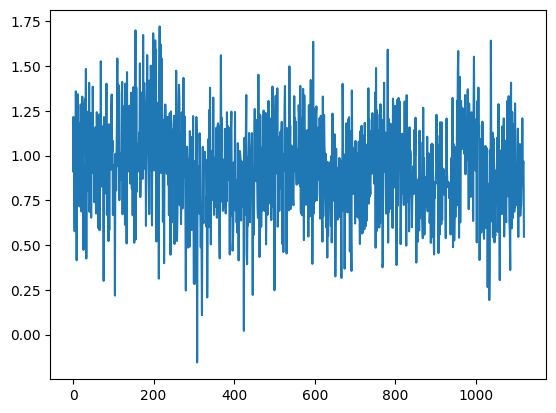

In [213]:
plt.plot(losses)

In [216]:
test_env = gym.make('CartPole-v1', render_mode='human')
test_model = model

for _ in range(5):
    state, info = test_env.reset()
    terminated, truncated = False, False
    while not (terminated or truncated):
        tensor_state = torch.from_numpy(state)
        logits = test_model(tensor_state)
        action_logits = logits[:-1]
        action = select_action(action_logits)
        state, reward, terminated, truncated, info = test_env.step(action)

test_env.close()